In [1]:
%cd ..
%ls 

from ch_est_net.preloading import *
from ch_est_net.utils import *

from ch_est_net.nets import *
from ch_est_net import Trainer

from torch.fft import fft, ifft, fftshift, ifftshift
from ch_est_net import activation

%load_ext autoreload
%autoreload 2

import torch
print(torch.__version__)

import wandb
USE_WANDB = False

/home/alex/GitHub/ML_for_channel_estimation
ch_est_net/        lista_beam_net.pt  output.svg        torchvix-sample
config_beams.yaml  model_image        __pycache__/      torchvix-sample.png
config.yaml        model_image.png    README.md         wandb/
data.h5            Notebooks/         requirements.txt  zero_150.pt
DMRS_signal/       one.pt             results/          zero.pt
1.10.1


In [2]:
cfg, dataL, dataS, device, deviceType, dtype, file, ml_default, onePilotFolder, path ,preload, print_function, scen0, Scenario = crazy_preloader()

Using CPU

Preload data: OK


In [3]:
def get_batch(snr_range, ind_range, seed):
    '''
    For files ind_range add noise with snr_range and stack all realizations to single array
    --------------------------------------------------------------------------
    RETURNS:
    pilot_batch -> [Realizations ; Antennas ; Subc ; Re/Im ]
    data_batch  -> [Realizations ; Antennas ; Subc ; 12? ; Re/Im]
    pilot_batch -> [Realizations]
    --------------------------------------------------------------------------
    Realizations = len(snr_range)*len(ind_range) 
    '''

    pilot_batch = torch.tensor(())
    pilot_noisy_batch = torch.tensor(())
    data_batch = torch.tensor(())
    noise_P_batch = torch.tensor(())

    for snr in snr_range:
        for ind in ind_range:
            h_pilot, h_data = data_load(scen0, dtype = dtype, onePilotFolder = onePilotFolder,dataL=dataL, ind = ind) 
                                                  # load data
            h_pilot_noisy, _ = add_noise(h_pilot, SNR = snr,scen=scen0, dtype=dtype, seed = seed)                             # add noise to pilots
            h_data_noisy, data_noise_power = add_noise_data(h_data, SNR = snr, dtype = dtype, seed = seed)     # add noise to data

            h_pilot = h_pilot.mean(dim = 2).unsqueeze(dim = 0)                                  # mean over pilots dim and add aditional dim
            h_pilot_noisy = h_pilot_noisy.mean(dim = 2).unsqueeze(dim = 0)

            h_data_noisy = h_data_noisy.unsqueeze(dim = 0)                                      # add additional dim for
            data_noise_power = data_noise_power.unsqueeze(dim =0)

            pilot_batch = torch.cat((pilot_batch, h_pilot), dim = 0)

            pilot_noisy_batch = torch.cat((pilot_noisy_batch, h_pilot_noisy), dim = 0)
            data_batch = torch.cat((data_batch, h_data_noisy), dim = 0)
            noise_P_batch = torch.cat((noise_P_batch, data_noise_power), dim = 0)

    return pilot_batch, pilot_noisy_batch, data_batch, noise_P_batch


# x_batch, u_batch, _, _ = get_batch(snr_range = [-12, -8, -6 , -3 ,0],
#                                             ind_range = range(1, 140, 3),
#                                             seed = 3)

x_batch, u_batch, _, _ = get_batch(snr_range = [-8],
                                            ind_range = range(1,140,2),
                                            seed = 3)



x_test, u_test, _, _ = get_batch(snr_range = [-10],
                                              ind_range = range(2, 141, 2),
                                              seed = 2)


x_batch = x_batch[:,:,:,0] + 1j*x_batch[:,:,:,1]
u_batch = u_batch[:,:,:,0] + 1j*u_batch[:,:,:,1]

x_test = x_test[:,:,:,0] + 1j*x_test[:,:,:,1]
u_test = u_test[:,:,:,0] + 1j*u_test[:,:,:,1]


In [4]:
def beam_time_transform(x):
    if len(x.shape)==2:
        x = torch.unsqueeze(x, dim = 0)

    x_a_t = ifft(x , n = 512, dim = 2, norm = 'ortho')
    x_a_t = torch.roll(x_a_t, shifts = 206, dims= 2)
    x_b_t = fft(x_a_t, n = 512, dim = 1, norm = 'ortho')

    return torch.squeeze(x_b_t, dim = 0)    

def ant_freq_transform(x):
    if len(x.shape)==2:
        x = torch.unsqueeze(x, dim = 0)
    
    x = torch.roll(x, shifts= -206, dims =2)
    x_a_t = ifft(x, n = 512, dim = 1, norm = 'ortho')
    x_a_t = x_a_t[:,:64,:]
    x_a_f = fft(x_a_t, n = 512, dim = 2, norm ='ortho')
    x_a_f = x_a_f[:,:,:48]
    
    return torch.squeeze(x_a_f, dim = 0)

In [5]:
from torch.nn.functional import mse_loss
def MSE(x_real, x_hat):
    '''Mean squared error generalized for complex values'''

    assert x_real.shape == x_hat.shape, 'Sizes of both values must be the same, but got {0} and {1} instead'.format(x_real.shape, x_hat.shape)
    
    if torch.is_complex(x_real):
        mse = torch.sum(torch.abs(x_real-x_hat)**2)/torch.numel(x_real)

    else:
        mse = mse_loss(x_real, x_hat)

    return mse

In [6]:
x_batch_spec = beam_time_transform(x_batch)
u_batch_spec = beam_time_transform(u_batch)
x_test_spec = beam_time_transform(x_test)
u_test_spec = beam_time_transform(u_test)

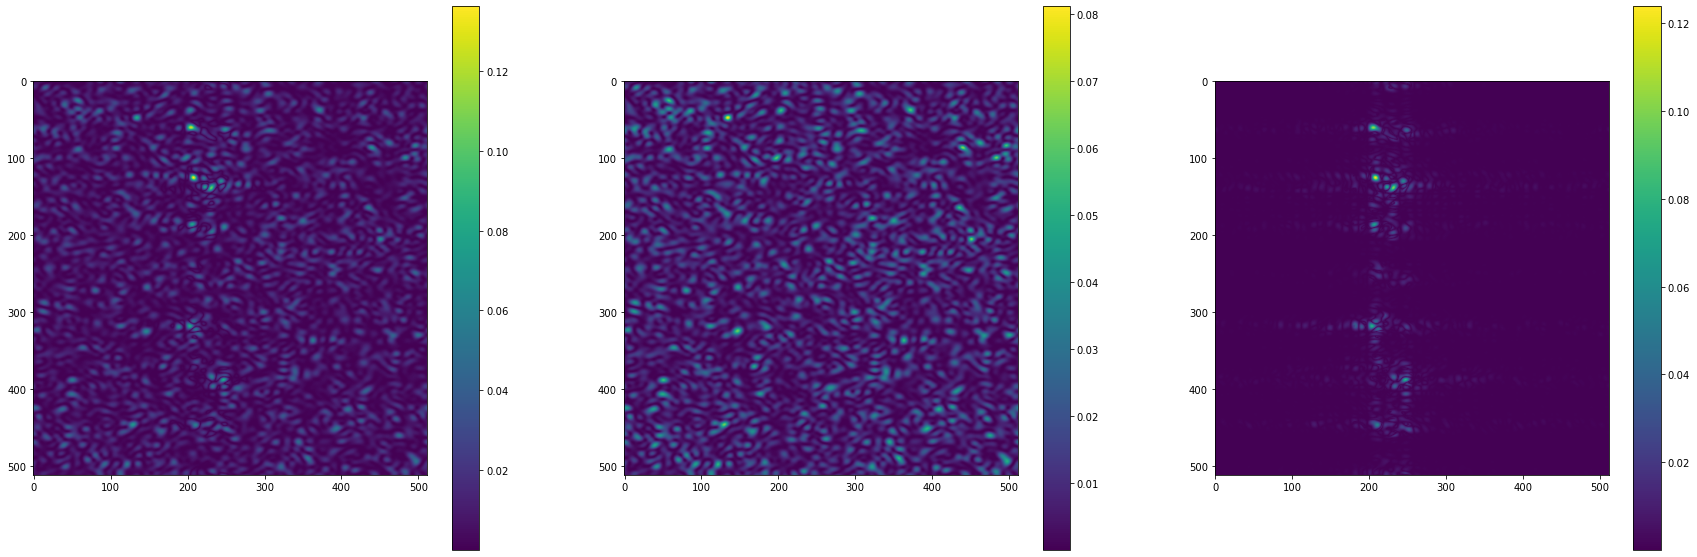

In [7]:
x = x_batch_spec[1]
u = u_batch_spec[1]  

plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(abs(abs(u)**2 - abs(x)**2))
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(abs(u-x)**2)
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(abs(abs(abs(u)**2 - abs(x)**2)- abs(u-x)**2))
plt.colorbar()


In [113]:
for i in range(70):
    m = torch.mean(u_batch_spec[i])
    s = torch.std(u_batch_spec[i], unbiased = False)
    
    u_batch_spec[i] -=m
    u_batch_spec[i] /=s 

In [120]:
#plt.figure(figsize=(10,10))
#ind = 10
#plt.imshow(abs(u_batch_spec[ind,:, :100]).T)
noise = abs(u_batch_spec[:,:, :100])
print(torch.mean(noise))
print(torch.std(noise))

tensor(0.1283)
tensor(0.2043)


In [121]:
noise = noise.permute(1,2,0)

In [35]:
noise = noise.reshape(512,-1)

In [46]:
noise.shape

torch.Size([512, 100, 70])

In [122]:
Nn = torch.tensor(())
for i in range(noise.shape[2]):
    Nn = torch.cat((Nn, noise[:,:,i]), 1) 

In [70]:
Nn.shape

torch.Size([512, 7000])

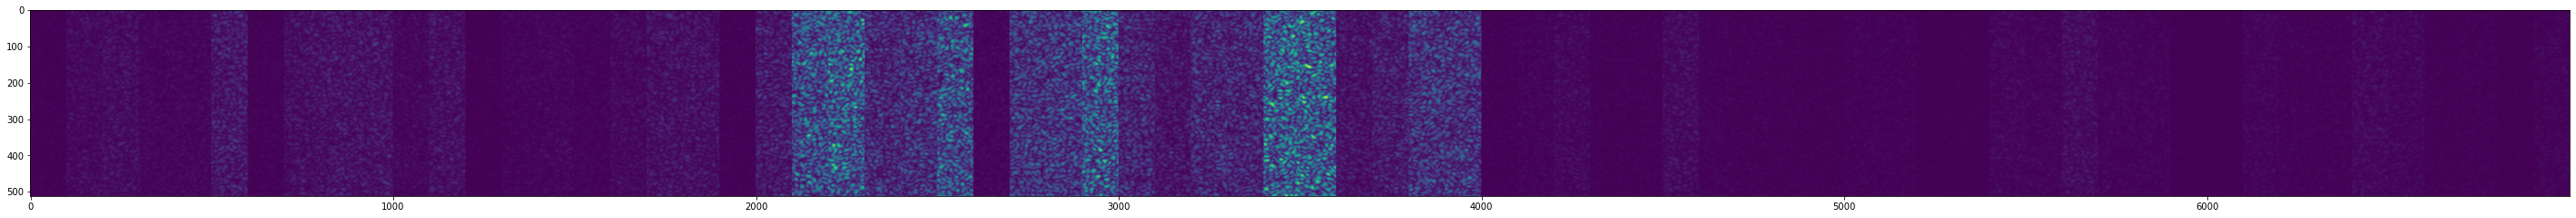

In [123]:
plt.figure(figsize=(50,5))
plt.imshow(abs(Nn)[:,:])

(0.0, 7000.0)

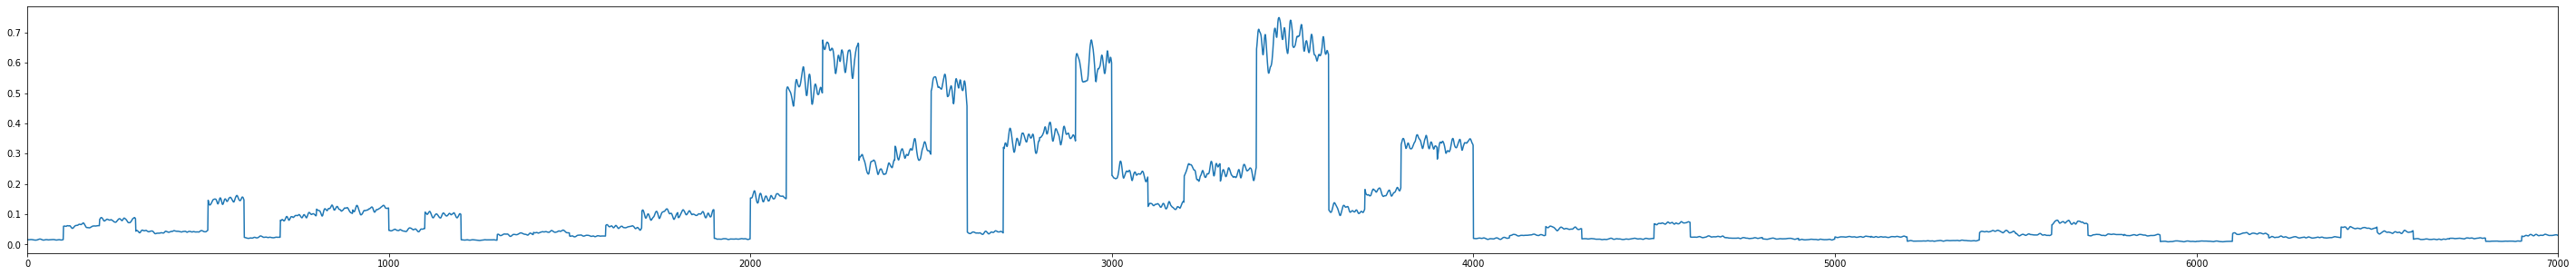

In [124]:
plt.figure(figsize=(50,5))
plt.plot(torch.mean(abs(Nn),0))
plt.xlim([0,7000])

(0.0, 7000.0)

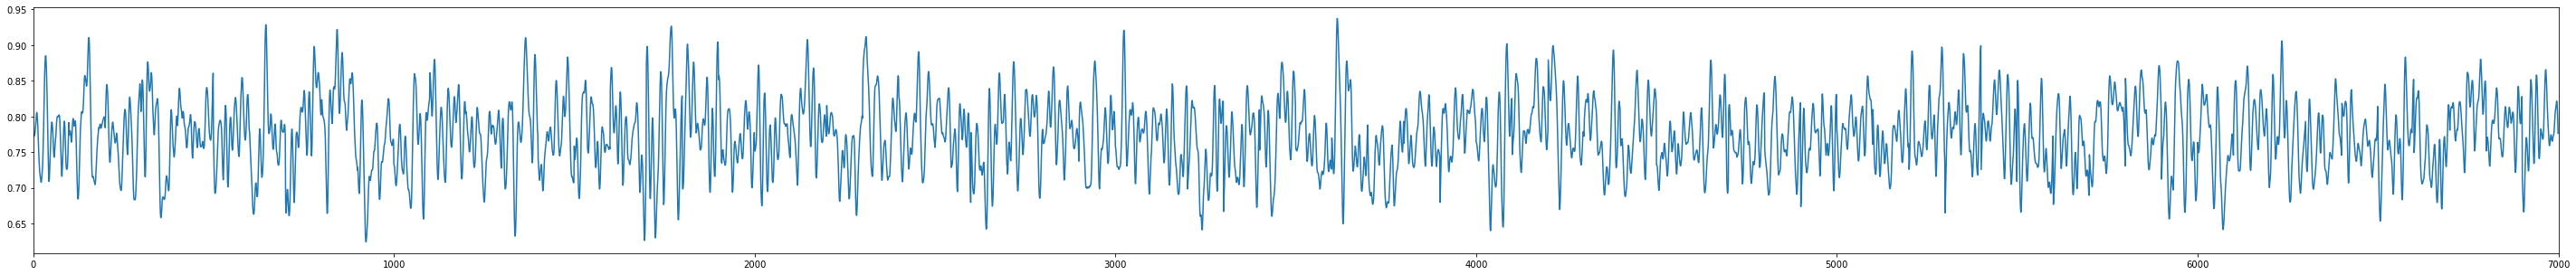

In [118]:
plt.figure(figsize=(50,5))
plt.plot(torch.mean(abs(Nn),0))
plt.xlim([0,7000])

(0.0, 7000.0)

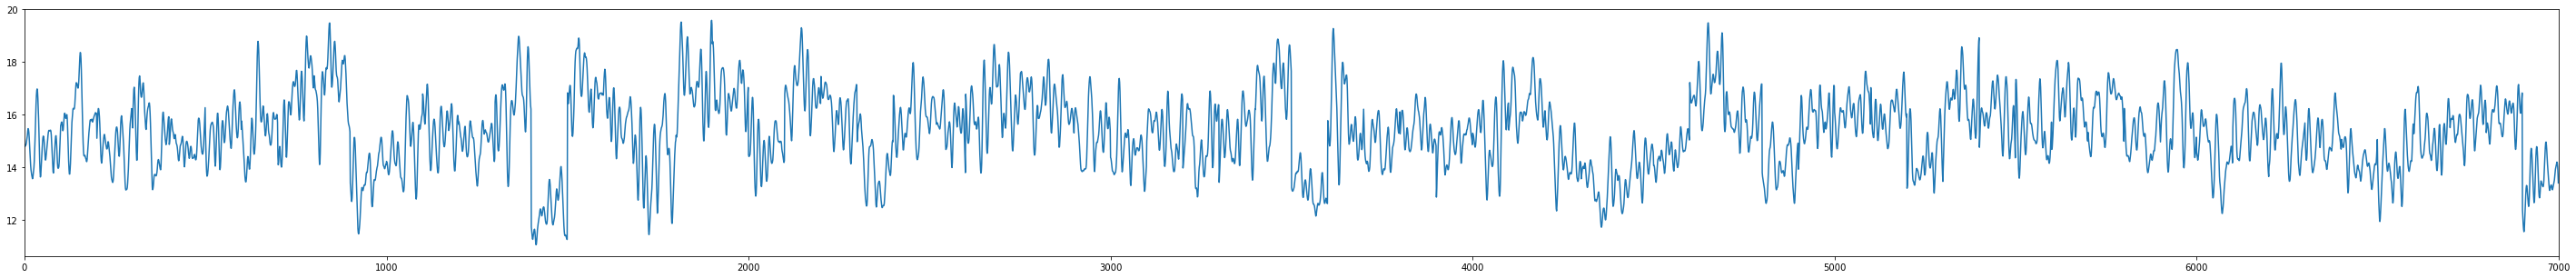

In [93]:
plt.figure(figsize=(50,5))
plt.plot(torch.sum(abs(Nn),0))
plt.xlim([0,7000])

In [9]:

class Thresholding_denoiser(torch.nn.Module):
    def __init__(self):
        super(Thresholding_denoiser, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(1.2001), requires_grad = True)
        self.beta = nn.Parameter(torch.tensor(0.1449), requires_grad = True)
        self.act = activation.Scaled_soft_threshold()

    def forward(self, u):

        mean_val = torch.mean(u);
        std_val = torch.std(u, unbiased = False);
        u -= mean_val
        u /= std_val

        x_hat = self.act(u, 1.0, self.alpha, self.beta)
        
        #x_hat *= std_val
        #x_hat +=mean_val
        
        return x_hat


model = Thresholding_denoiser()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer= optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 10,
    threshold = 1e-3,
    threshold_mode = 'rel',
    cooldown = 10,
    min_lr= 1e-5
)

In [14]:
train_loss_hist = []
test_loss_hist = []

max_loss_train = MSE(u_batch_spec, x_batch_spec).item()
max_loss_test = MSE(u_test_spec, x_test_spec).item()

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()

    u = u_batch_spec
    x = x_batch_spec

    x_hat = model(u)
    loss = MSE(x_hat,x)
    loss.backward()
    optimizer.step()

    train_loss_hist.append(loss.item())
    nmse_train = round(loss.item()/max_loss_train*100, 2)

    model.eval()
    with torch.no_grad():
        u = u_test_spec
        x = x_test_spec

        h_hat = model(u)
        test_loss = MSE(h_hat,x)

        test_loss_hist.append(test_loss.item())
        scheduler.step(test_loss.item())
        nmse_test = round(test_loss.item() / max_loss_test*100, 2)
    
    if scheduler.optimizer.param_groups[0]['lr'] < 1e-4:
        print("Min lr has been exceded")
        break
    
    print("Epoch:{} | Train Loss: {} | Test Loss: {} | Alpha: {} | Beta: {} ".format(epoch, nmse_train, nmse_test, round(model.alpha.item(),4), round(model.beta.item(),4)   ))
    


Epoch:0 | Train Loss: 1.33 | Test Loss: 1.12 | Alpha: 1.1657 | Beta: 0.1859 
Epoch:1 | Train Loss: 1.33 | Test Loss: 1.12 | Alpha: 1.1657 | Beta: 0.1858 
Epoch:2 | Train Loss: 1.33 | Test Loss: 1.12 | Alpha: 1.1658 | Beta: 0.1857 
Epoch:3 | Train Loss: 1.33 | Test Loss: 1.12 | Alpha: 1.1659 | Beta: 0.1856 
Epoch:4 | Train Loss: 1.33 | Test Loss: 1.12 | Alpha: 1.1659 | Beta: 0.1855 
Epoch:5 | Train Loss: 1.33 | Test Loss: 1.12 | Alpha: 1.166 | Beta: 0.1854 
Epoch:6 | Train Loss: 1.33 | Test Loss: 1.12 | Alpha: 1.166 | Beta: 0.1853 
Epoch:7 | Train Loss: 1.33 | Test Loss: 1.12 | Alpha: 1.1661 | Beta: 0.1852 
Epoch:8 | Train Loss: 1.33 | Test Loss: 1.12 | Alpha: 1.1661 | Beta: 0.1851 
Epoch:9 | Train Loss: 1.33 | Test Loss: 1.12 | Alpha: 1.1662 | Beta: 0.1849 
Epoch:10 | Train Loss: 1.33 | Test Loss: 1.12 | Alpha: 1.1662 | Beta: 0.1848 
Epoch:11 | Train Loss: 1.33 | Test Loss: 1.12 | Alpha: 1.1663 | Beta: 0.1847 
Epoch:12 | Train Loss: 1.33 | Test Loss: 1.11 | Alpha: 1.1664 | Beta: 0.1846

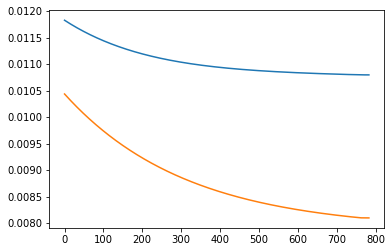

In [15]:
plt.plot(train_loss_hist)
plt.plot(test_loss_hist)

In [18]:
model.beta

Parameter containing:
tensor(1.2082, requires_grad=True)

In [31]:
# Вызов функции
SNR_range = range(-12,1,2)
scenario_range = range(1, 140, 2)

detector_error_beam_net_1, losses = get_detector_error(method= model, is_complex=True, 
            dtype = dtype, onePilotFolder=onePilotFolder,dataL=dataL,
            inds=scenario_range,
            scen = scen0,
            ml = ml_default,
            SNR_L=SNR_range,
            precoding=beam_time_transform ,
            aftercoding=ant_freq_transform)


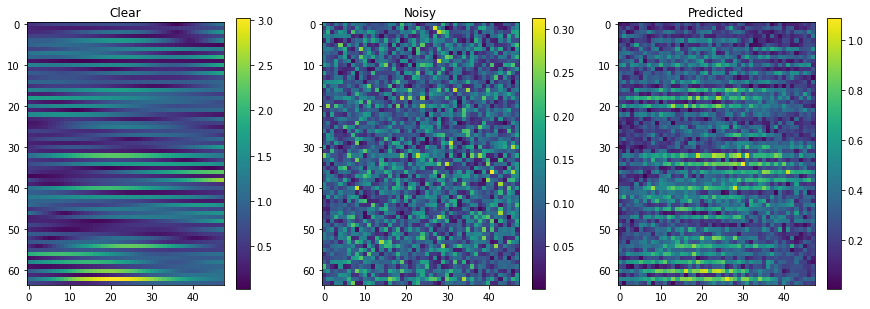

In [27]:
idx = 13

M = torch.mean(x_test[idx])
V = torch.std(x_test[idx], unbiased= False )

x_test[idx] -= M 
x_test[idx] /=V


plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(abs(x_test[idx]))
plt.title('Clear')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(abs(u_test[idx]))
plt.title('Noisy')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(abs(ant_freq_transform(model(beam_time_transform(u_test[idx]))).detach().numpy()))
plt.title('Predicted')
plt.colorbar()

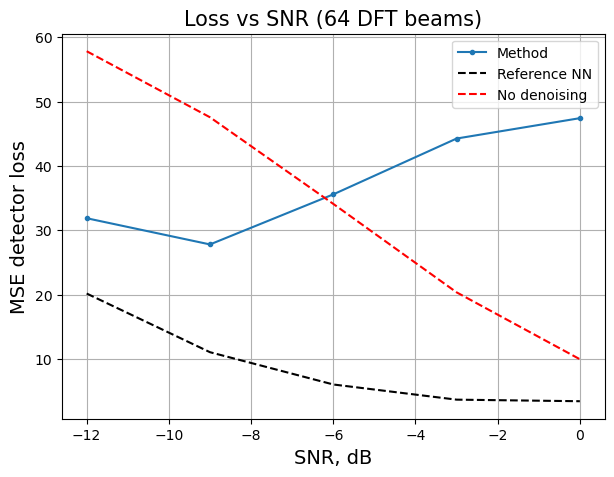

In [30]:
reference = [20.1498, 11.0312,6.0139, 3.6551, 3.4109 ]
noise = [57.8161, 47.5496, 34.0860, 20.339, 9.9376]
SNR_range = range(-12,1,3)
lista_beam_net_1 = [22.4750, 11.875, 6.335, 3.123, 2.094]
lista_beam_net_2 = [21.1612, 10.924, 6.216, 3.526, 3.194]

import matplotlib.pyplot as plt
plt.style.use("default")

plt.figure(figsize=(7,5))
plt.plot(SNR_range,detector_error_beam_net_1,'.-' ,label = 'Method')
plt.plot(SNR_range,reference,'--k',label = 'Reference NN' )
plt.plot(SNR_range,noise,'--r',label = 'No denoising' )

plt.legend()
plt.title("Loss vs SNR (64 DFT beams)", fontsize = 15)
plt.xlabel("SNR, dB" , fontsize = 14)
plt.ylabel("MSE detector loss", fontsize = 14);
#plt.ylim([0 , 48])
plt.grid()


plt.show()

In [33]:
x_batch, u_batch, _, _ = get_batch(snr_range = [0],
                                            ind_range = range(1,140,2),
                                            seed = 3)
                                            
x_batch = x_batch[:,:,:,0] + 1j*x_batch[:,:,:,1]
u_batch = u_batch[:,:,:,0] + 1j*u_batch[:,:,:,1]

In [49]:
MSE(res, u_batch[1])

tensor(0.3028)

tensor(1.2215)

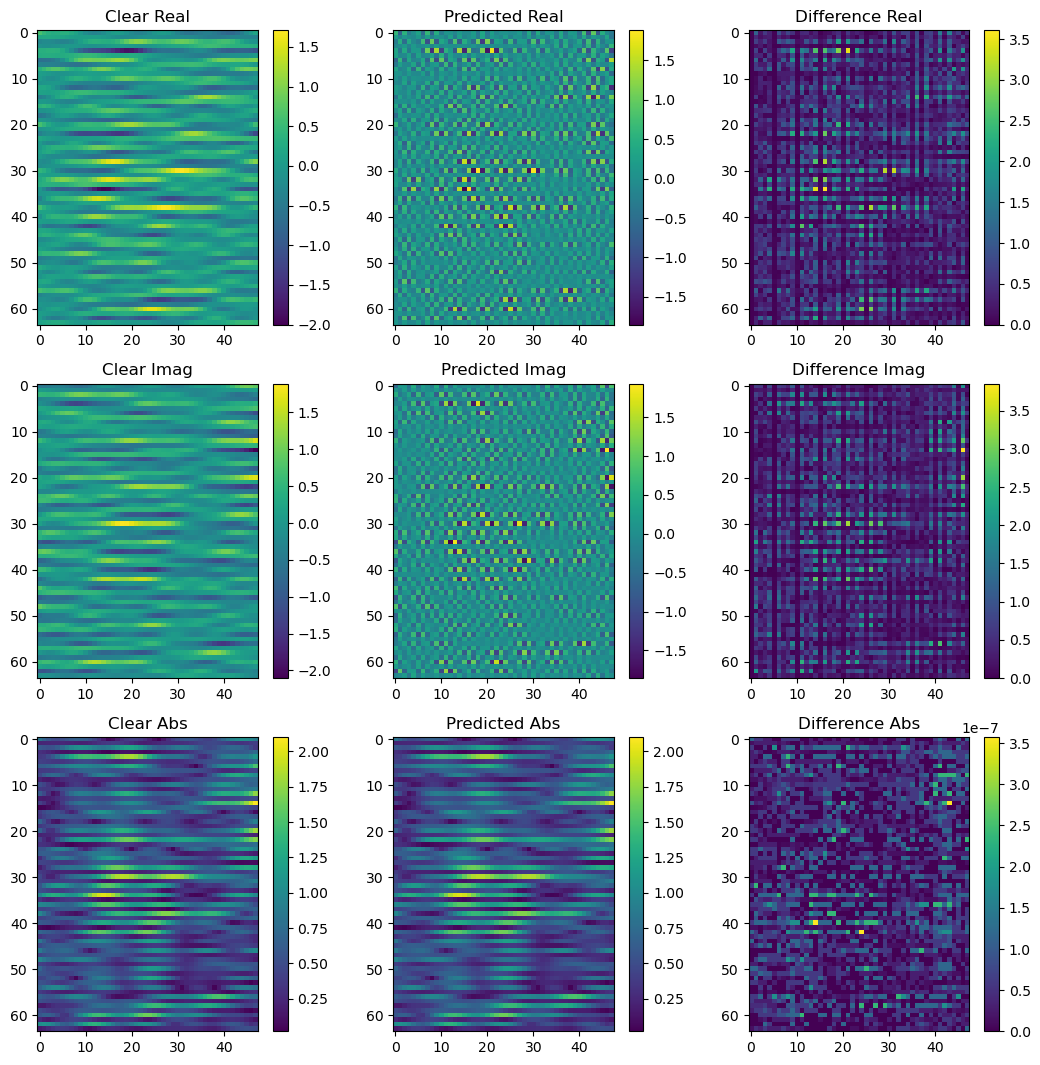

In [94]:
idx = 9
res = ant_freq_transform(beam_time_transform(x_batch[idx]))

## REAL
plt.figure(figsize=(13,13))
plt.subplot(3,3,1)
plt.imshow((x_batch[idx]).real)
plt.title('Clear Real')
plt.colorbar()

plt.subplot(3,3,2)
plt.imshow((res).real)
plt.title('Predicted Real')
plt.colorbar()

plt.subplot(3,3,3)
plt.imshow(abs((res).real - (x_batch[idx]).real))
plt.title('Difference Real')
plt.colorbar()

# imag
plt.subplot(3,3,4)
plt.imshow((x_batch[idx]).imag)
plt.title('Clear Imag')
plt.colorbar()

plt.subplot(3,3,5)
plt.imshow((res).imag)
plt.title('Predicted Imag')
plt.colorbar()

plt.subplot(3,3,6)
plt.imshow(abs(res.imag - (x_batch[idx]).imag))
plt.title('Difference Imag')
plt.colorbar()

#
plt.subplot(3,3,7)
plt.imshow(abs(x_batch[idx]))
plt.title('Clear Abs')
plt.colorbar()

plt.subplot(3,3,8)
plt.imshow(abs(res))
plt.title('Predicted Abs')
plt.colorbar()

plt.subplot(3,3,9)
plt.title('Difference Abs')
plt.imshow(abs(abs(res) - abs(x_batch[idx])))
plt.colorbar()


MSE(res, u_batch[idx])

In [ ]:
idx =32
res = ant_freq_transform(beam_time_transform(x_batch[idx]))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow((x_batch[idx]).imag)
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow((res).real)
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(((res).real - (x_batch[idx]).real))
plt.colorbar()

MSE(res, u_batch[idx])

In [41]:
lr = 0.1
alpha = torch.tensor(0.35, requires_grad = True)
beta = torch.tensor(0.2346, requires_grad = True)

loss_hist = []

for i in range(1000):
    epoch_loss = torch.zeros(1)
    
    u = u_batch_spec[:,:,:]
    x = x_batch_spec[:,:,:]

    err = MSE(x, u*beta)
    L1 = alpha*abs(err)

    epoch_loss = epoch_loss + err + L1
    epoch_loss.backward()

    loss_hist.append(epoch_loss.item())

    with torch.no_grad():
        alpha -= lr*alpha.grad
        beta -= lr*beta.grad

        alpha.grad = None
        beta.grad = None
    print("Epoch: {}, Loss: {}, Alpha: {}, Beta:{}".format(i, epoch_loss.item(), alpha.item(), beta.item()))

    


Epoch: 0, Loss: 0.028794795274734497, Alpha: 0.9985602498054504, Beta:0.20108430087566376
Epoch: 1, Loss: 0.02876250259578228, Alpha: 0.9971210956573486, Beta:0.20213395357131958
Epoch: 2, Loss: 0.028730951249599457, Alpha: 0.9956824779510498, Beta:0.20315007865428925
Epoch: 3, Loss: 0.028700102120637894, Alpha: 0.994244396686554, Beta:0.2041337639093399
Epoch: 4, Loss: 0.028669897466897964, Alpha: 0.9928067922592163, Beta:0.20508608222007751
Epoch: 5, Loss: 0.02864031493663788, Alpha: 0.9913696050643921, Beta:0.20600804686546326
Epoch: 6, Loss: 0.02861129678785801, Alpha: 0.9899328351020813, Beta:0.20690064132213593
Epoch: 7, Loss: 0.02858281508088112, Alpha: 0.9884964823722839, Beta:0.20776483416557312
Epoch: 8, Loss: 0.02855483628809452, Alpha: 0.9870604872703552, Beta:0.20860153436660767
Epoch: 9, Loss: 0.028527328744530678, Alpha: 0.9856248497962952, Beta:0.2094116359949112
Epoch: 10, Loss: 0.028500260785222054, Alpha: 0.984189510345459, Beta:0.21019600331783295
Epoch: 11, Loss: 0

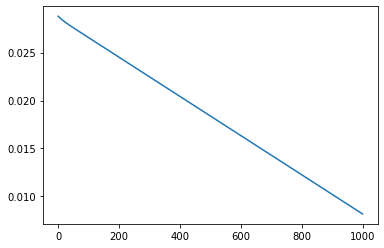

In [42]:
plt.plot(loss_hist)

In [11]:
class Time_Beam_Transform(torch.nn.Module):
    def __init__(self, n_time, n_beams):
        super(Time_Beam_Transform, self).__init__()
        self.n_time = n_time
        self.n_beams = n_beams
    
    def forward(self, x):
        x = ifft(x, n = self.n_time, dim = 1, norm = 'ortho')
        x = torch.roll(x, shifts = self.n_time//2, dims = 1)
        x = fft(x, n = self.n_beams, dim = 0, norm = 'ortho')
        return x  


class Energy_cut(torch.nn.Module):
    def __init__(self):
        super(Energy_cut, self).__init__()
        self.alpha = torch.nn.Parameter(torch.tensor(0.3,requires_grad = True))
        self.beta = torch.nn.Parameter(torch.tensor(1.0,requires_grad = True))


    def forward(self, x):
        power = abs(x)**2
        zero = torch.zeros(power.shape)
        res = self.beta * torch.maximum(power - self.alpha, zero)
        res[res != 0] = 1
        return res*x


class Freq_Ant_Transform(torch.nn.Module):
    def __init__(self, n_freq, n_ants):
        super(Freq_Ant_Transform, self).__init__()
        self.n_freq = n_freq
        self.n_ants = n_ants
    
    def forward(self, x):
        x = ifft(x, n = x.shape[0], dim = 0, norm = 'ortho')
        x = x[:self.n_ants,:]
        x = torch.roll(x, shifts = -x.shape[1]//2, dims = 1)

        x = fft(x, n = x.shape[1], dim = 1, norm = 'ortho')
        x = x[:,:self.n_freq]
        return x 

class Energy_Net(torch.nn.Module):
    def __init__(self):
        super(Energy_Net, self).__init__()
        
        self.forward_layer = Time_Beam_Transform(512,512)
        self.cuter = Energy_cut()
        self.backward_layer = Freq_Ant_Transform(48,64) 
        #self.net = torch.nn.ModuleList[Time_Beam_Transform(512,512), Energy_cut(), Freq_Ant_Transform(48,64)]
    
    def forward(self,x):
        x = self.forward_layer(x)
        x = self.cuter(x)
        x = self.backward_layer(x) 
        return x


from torch.nn.functional import mse_loss
def MSE(x_real, x_hat):
    '''Mean squared error generalized for complex values'''

    assert x_real.shape == x_hat.shape, 'Sizes of both values must be the same, but got {0} and {1} instead'.format(x_real.shape, x_hat.shape)
    
    if torch.is_complex(x_real):
        mse = torch.sum(torch.abs(x_real-x_hat)**2)/torch.numel(x_real)

    else:
        mse = mse_loss(x_real, x_hat)

    return mse

In [12]:
model = Energy_Net()
optimizer = torch.optim.Adam(model.parameters(), lr = 1.0e-3)


In [13]:
def train(model, optimizer,criterion, clear_data, noisy_data, clear_test, noisy_test ,  epochs, device = 'cpu'):
        previous_loss_value = 0
        degrade_counter = 0

        for epoch in range(epochs):
            model.train()
            current_mse = torch.tensor(0.0, dtype= torch.float64)
            test_mse = torch.tensor(0.0, dtype= torch.float64)
            
            optimizer.zero_grad()

            for cur_data_idx in range(clear_data.shape[0]):
                x = clear_data[cur_data_idx,:].type(torch.complex64).detach()
                y = noisy_data[cur_data_idx,:].type(torch.complex64).detach()

                x_hat = model(y)
                current_mse += criterion(x,x_hat)
            
            current_mse.backward()
            optimizer.step()
            #train_loss_history.append(current_mse.detach().item())

            # -------------TESTING------------- 
            model.eval()
            with torch.no_grad():
                for cur_data_idx in range(clear_test.shape[0]):
                    
                    #if epoch%5==0:
                    #    if cur_data_idx == 0:
                    #        self.model.is_save_log = True

                    x = clear_test[cur_data_idx,:].type(torch.complex64).detach()
                    y = noisy_test[cur_data_idx,:].type(torch.complex64).detach()

                    #if epoch%5==0:
                    #    if cur_data_idx == 0:
                    #        res = self.model(y, True)
                    #else:
                    res = model(y)

                    test_mse += criterion(x, res)
                

            #self.test_loss_history.append(test_mse.item())
            if epoch%1 == 0:
                print('Epoch: {0}. Train Loss : {1:9.5f}. Test Loss: {2:9.5f}'.format(epoch,current_mse.item(), test_mse.item()))

            #if self.scheduler.optimizer.param_groups[0]['lr'] < 1e-4:
            #    break
            
            if test_mse.item() > previous_loss_value:
                degrade_counter += 1

                #if degrade_counter > 50:
                #    break
            
            elif degrade_counter > 0:
                degrade_counter -=1

            previous_loss_value = current_mse.item()
            
            #self.scheduler.step(test_mse.detach().item())
            


In [ ]:
idx = 9
xx = beam_time_transform(x_batch[idx])
xxx = model(xx)
xxxx = ant_freq_transform(xxx)

In [15]:
train(model, optimizer, MSE, x_batch, u_batch,x_test,u_test, 1000)

Epoch: 0. Train Loss : 1654.76059. Test Loss: 290.10816
Epoch: 1. Train Loss : 1652.84719. Test Loss: 289.65068
Epoch: 2. Train Loss : 1651.56480. Test Loss: 289.30985
Epoch: 3. Train Loss : 1650.57845. Test Loss: 288.81632
Epoch: 4. Train Loss : 1649.20375. Test Loss: 288.41723
Epoch: 5. Train Loss : 1648.03787. Test Loss: 287.92134
Epoch: 6. Train Loss : 1646.63371. Test Loss: 287.36849
Epoch: 7. Train Loss : 1645.07751. Test Loss: 286.89430
Epoch: 8. Train Loss : 1643.69736. Test Loss: 286.38776
Epoch: 9. Train Loss : 1642.23407. Test Loss: 285.86160
Epoch: 10. Train Loss : 1640.76306. Test Loss: 285.38624
Epoch: 11. Train Loss : 1639.39875. Test Loss: 284.95638
Epoch: 12. Train Loss : 1638.20477. Test Loss: 284.58319
Epoch: 13. Train Loss : 1637.13542. Test Loss: 284.22823
Epoch: 14. Train Loss : 1636.15139. Test Loss: 283.88115
Epoch: 15. Train Loss : 1635.15067. Test Loss: 283.56128
Epoch: 16. Train Loss : 1634.24397. Test Loss: 283.28817
Epoch: 17. Train Loss : 1633.44330. Test 

KeyboardInterrupt: 

In [16]:
# Вызов функции
SNR_range = range(-12,1,3)
scenario_range = range(1, 140, 2)

detector_error_beam_net_1, losses = get_detector_error(method= model,is_complex=True, 
            dtype = dtype, onePilotFolder=onePilotFolder,dataL=dataL,
            inds=scenario_range,
            scen = scen0,
            ml = ml_default,
            SNR_L=SNR_range)


/home/alex/GitHub/ML_for_channel_estimation/ch_est_net/utils.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = torch.tensor(u[:,:,0] + 1j*u[:,:,1], dtype = torch.complex64)


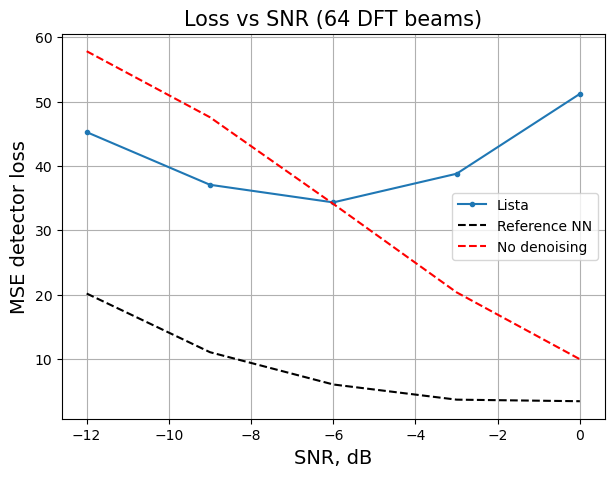

In [17]:

reference = [20.1498, 11.0312,6.0139, 3.6551, 3.4109 ]
noise = [57.8161, 47.5496, 34.0860, 20.339, 9.9376]
SNR_range = range(-12,1,3)
lista_beam_net_1 = [22.4750, 11.875, 6.335, 3.123, 2.094]
lista_beam_net_2 = [21.1612, 10.924, 6.216, 3.526, 3.194]

import matplotlib.pyplot as plt
plt.style.use("default")

plt.figure(figsize=(7,5))
plt.plot(SNR_range,detector_error_beam_net_1,'.-' ,label = 'Lista')
plt.plot(SNR_range,reference,'--k',label = 'Reference NN' )
plt.plot(SNR_range,noise,'--r',label = 'No denoising' )

plt.legend()
plt.title("Loss vs SNR (64 DFT beams)", fontsize = 15)
plt.xlabel("SNR, dB" , fontsize = 14)
plt.ylabel("MSE detector loss", fontsize = 14);
#plt.ylim([0 , 48])
plt.grid()


plt.show()